### Indexes and index sets

* $n \in N$: Set of nodes
* $i \in G$: Set of generators. Each generator is associated with a node $n$.
* $b \in B$: Set of branches
* $b \in B_n^{in}$: Set of branches coming into node $n$
* $b \in B_n^{out}$: Set of branches going out of node $n$
* $t \in T$: Set of time periods
* $i \in G_n$: Set of generators at node $n$

### Parameters

* $P_{i}^{\min}$: Minimum power output of generator $i$ (MW)
* $P_{i}^{\max}$: Maximum power output of generator $i$ (MW)
* ${VOLL}$: Value of lost load (cost of load shedding) ($/MWh)
* $MC_{i}$: Marginal cost of generator $i$ (\$/MWh)
* $CO2_{i}$ Cost of CO2 emissions of generator $i$ (\$/MWh)
* $E_{i}$: CO2 emissions of generator $i$ (ton/MWh) 
* $E_{limit}$: CO2 emissions limit (ton)
* $D_{n,t}$: Demand at node $n$ and time $t$ (MW)
* $l_b$: loss factor of branch $b$ (given, but in reality some function of distance, transmsission line type, etc.)
* $P_{b}^{\max}$: Maximum power flow on branch $b$ (MW)

### Decision variables
* $g_{i,t}$: Power generation dispatch of generator $i$ at time $t$ (MW)
* $f_{b,t}$: Power flow on branch $b$ at time $t$ (MW)
* $s_{n,t}$: Load shedding at node $n$ at time $t$ (MW)
* $c_{n,t}$: Power curtailment at node $n$ at time $t$ (MW)

### Optimization Model

### Objective function, minimize cost of generation

**Minimize:**
$$ \sum_{i \in G} \sum_{t \in T} (MC_i + CO2_i) g_{i,t} + \sum_{n \in N} \sum_{t \in T} s_{n,t} VOLL + \sum_{n \in N} \sum_{t \in T} c_{n,t} CC$$

1. **Power balance: production + inflow - curtailment = outflow + demand - shedding**

*A.K.A. Market clearing or energy balance*

$$ \sum_i (g_{i,t} - c_{i,t}) + \sum_{b \in B_n^{in}} f_{b,t}(1-l_b) - \sum_{b \in B_n^{out}} f_{b,t} + s_{n,t} = D_{n,t} \quad \forall n \in N, \forall t \in T $$

2. **We can't shed more load than the demand**

$$ s_{n,t} \leq D_{n,t} \quad \forall n \in N, \forall t \in T $$

3. **Generators' power output limits**

$$ P_{i}^{\min} \leq g_{i,t} \leq P_{i}^{\max} \quad \forall i \in G, \forall t \in T $$

4. **Branch power flow limits**

$$ -P_{b}^{\max} \leq f_{b,t} \leq P_{b}^{\max} \quad \forall b \in B, \forall t \in T $$

5. **Emissions restrictions**

$$ \sum_i \sum_t E_i g_{i,t} \leq E_{limit} $$

6. **Variable definitions**

$$ g_{i,t} \geq 0, \quad f_{b,t} \geq 0, \quad s_{n,t} \geq 0, \quad c_{n,t} \geq 0 \quad \forall i \in G, \forall b \in B, \forall n \in N, \forall t \in T $$

# Basic model implementation

In [1]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import os
import numpy as np

np.random.seed(0)

In [2]:
DATA_FOLDER = os.path.join(os.path.dirname(os.getcwd()), "data")

In [3]:
branches = pd.read_csv(os.path.join(DATA_FOLDER, "branches.csv"))
nodes = pd.read_csv(os.path.join(DATA_FOLDER, "nodes.csv"))
generators = pd.read_csv(os.path.join(DATA_FOLDER, "generators.csv"))
hourly_demand = pd.read_csv(os.path.join(DATA_FOLDER, "hourly_demand.csv"))

In [4]:
branch_out_mapping = {
    node_id: branches[branches["node_from"] == node_id]["branch_id"].values
    for node_id in nodes["node_id"]
}
branch_in_mapping = {
    node_id: branches[branches["node_to"] == node_id]["branch_id"].values
    for node_id in nodes["node_id"]
}

In [5]:
print(branch_out_mapping)
print(branch_in_mapping)

{0: array([0, 1, 2], dtype=int64), 1: array([3, 4, 5], dtype=int64), 2: array([6, 7, 8], dtype=int64), 3: array([9], dtype=int64), 4: array([10], dtype=int64), 5: array([11, 12], dtype=int64), 6: array([13], dtype=int64), 7: array([], dtype=int64), 8: array([], dtype=int64), 9: array([], dtype=int64)}
{0: array([], dtype=int64), 1: array([], dtype=int64), 2: array([], dtype=int64), 3: array([5, 8], dtype=int64), 4: array([4, 6], dtype=int64), 5: array([1], dtype=int64), 6: array([9], dtype=int64), 7: array([ 2, 10, 11, 13], dtype=int64), 8: array([ 3, 12], dtype=int64), 9: array([0, 7], dtype=int64)}


In [6]:
# Initialize model
model = gp.Model("power_flow_optimization")

# Sets
N = nodes["node_id"].tolist()  # Set of nodes
G = generators["generator_id"].tolist()  # Set of generators
B = branches["branch_id"].tolist()  # Set of branches
T = hourly_demand["hour"].unique().tolist()  # Set of time periods

# Parameters
VOLL = 1e3  # Example value for Value of Lost Load (set appropriately)
curtailment_cost = 0  # Example value for curtailment cost (set appropriately)
P_min = {
    row["generator_id"]: row["pmin"] for _, row in generators.iterrows()
}  # Minimum generation
P_max = {
    row["generator_id"]: row["pmax"] for _, row in generators.iterrows()
}  # Maximum generation
MC = {
    row["generator_id"]: row["MC"] for _, row in generators.iterrows()
}  # Marginal cost
CO2 = {row["generator_id"]: row["CO2"] for _, row in generators.iterrows()}  # CO2 cost
D = {
    (row["node_id"], row["hour"]): row["demand"] for _, row in hourly_demand.iterrows()
}  # Demand at node n, time t
E = {
    row["generator_id"]: row["CO2"] for _, row in generators.iterrows()
}  # Emissions factor
E_limit = GRB.INFINITY  # Example CO2 emissions limit
P_b_max = {
    row["branch_id"]: row["capacity"] for _, row in branches.iterrows()
}  # Branch power flow limits
loss_factor = {
    row["branch_id"]: row["loss_factor"] for _, row in branches.iterrows()
}  # Loss factor for each branch

# Decision Variables
g = model.addVars(G, T, lb=0, ub=GRB.INFINITY, name="generation")  # Generation dispatch
f = model.addVars(B, T, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="flow")  # Power flow
s = model.addVars(N, T, lb=0, name="shedding")  # Load shedding
c = model.addVars(N, T, lb=0, name="curtailment")  # Power curtailment

# Objective: Minimize total generation cost (MC + CO2 cost + shed cost)
obj = gp.quicksum((MC[i] + CO2[i]) * g[i, t] for i in G for t in T) + gp.quicksum(
    VOLL * s[n, t] + curtailment_cost * c[n, t] for n in N for t in T
)
model.setObjective(obj, GRB.MINIMIZE)

# Constraint 1: Power balance at each node and time
for n in N:
    for t in T:
        inflow = gp.quicksum(
            f[b, t] * (1 - loss_factor[b]) for b in branch_in_mapping[n]
        )
        outflow = gp.quicksum(f[b, t] for b in branch_out_mapping[n])
        generation = gp.quicksum(
            g[i, t] for i in generators[generators["node_id"] == n]["generator_id"]
        )
        curtailment = c[n, t]
        demand = D[n, t]
        model.addConstr(
            generation - curtailment + inflow - outflow + s[n, t] == demand,
            f"power_balance_{n}_{t}",
        )

# Constraint 2: Load shedding can't exceed demand
for n in N:
    for t in T:
        model.addConstr(s[n, t] <= D[n, t], f"shedding_limit_{n}_{t}")

# Constraint 3: Generator output limits
for i in G:
    for t in T:
        model.addConstr(g[i, t] >= P_min[i], f"gen_min_{i}_{t}")
        model.addConstr(g[i, t] <= P_max[i], f"gen_max_{i}_{t}")

# Constraint 4: Branch power flow limits
for b in B:
    for t in T:
        model.addConstr(f[b, t] <= P_b_max[b], f"branch_max_{b}_{t}")
        model.addConstr(f[b, t] >= -P_b_max[b], f"branch_min_{b}_{t}")

# Constraint 5: CO2 emissions limit
model.addConstr(
    gp.quicksum(E[i] * g[i, t] for i in G for t in T) <= E_limit, "emissions_limit"
)

# Optimize the model
model.optimize()

# Extract the results
if model.status == GRB.OPTIMAL:
    generation = model.getAttr("x", g)
    flow = model.getAttr("x", f)
    shedding = model.getAttr("x", s)
    curtailment = model.getAttr("x", c)

    # Display results as needed

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-27
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3073 rows, 2016 columns and 5472 nonzeros
Model fingerprint: 0x219eb841
Coefficient statistics:
  Matrix range     [7e-01, 1e+00]
  Objective range  [5e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2689 rows and 576 columns
Presolve time: 0.01s
Presolved: 384 rows, 1440 columns, 2016 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2608440e+05   2.466595e+04   0.000000e+00      0s
     556    5.9701470e+05   0.000000e+00   0.000000e+00    

In [7]:
import pandas as pd

# Create empty dictionaries for each result
gen_results = {}
flow_results = {}
shedding_results = {}
curtailment_results = {}

# Extract generation results
for i in G:
    for t in T:
        gen_results[(i, t)] = generation[i, t]

# Extract flow results
for b in B:
    for t in T:
        flow_results[(b, t)] = flow[b, t]

# Extract load shedding results
for n in N:
    for t in T:
        shedding_results[(n, t)] = shedding[n, t]

# Extract curtailment results
for n in N:
    for t in T:
        curtailment_results[(n, t)] = curtailment[n, t]

# Convert results into dataframes for easier analysis
gen_df = pd.DataFrame.from_dict(
    gen_results, orient="index", columns=["Generation"]
).reset_index()

# Split the 'index' column (which contains tuples) into two separate columns: 'Generator' and 'Time'
gen_df[["Generator", "Time"]] = pd.DataFrame(gen_df["index"].tolist())
gen_df = gen_df.drop(columns=["index"])
gen_df = gen_df[["Generator", "Time", "Generation"]]
gen_df.columns = ["Generator", "Time", "Generation (MW)"]

flow_df = pd.DataFrame.from_dict(
    flow_results, orient="index", columns=["Flow"]
).reset_index()
flow_df[["Branch", "Time"]] = pd.DataFrame(flow_df["index"].tolist())
flow_df = flow_df.drop(columns=["index"])
flow_df = flow_df[["Branch", "Time", "Flow"]]
flow_df.columns = ["Branch", "Time", "Flow (MW)"]

shedding_df = pd.DataFrame.from_dict(
    shedding_results, orient="index", columns=["Shedding"]
).reset_index()
shedding_df[["Node", "Time"]] = pd.DataFrame(shedding_df["index"].tolist())
shedding_df.drop(columns=["index"], inplace=True)
shedding_df = shedding_df[["Node", "Time", "Shedding"]]
shedding_df.columns = ["Node", "Time", "Shedding (MW)"]

curtailment_df = pd.DataFrame.from_dict(
    curtailment_results, orient="index", columns=["Curtailment"]
).reset_index()
curtailment_df[["Node", "Time"]] = pd.DataFrame(curtailment_df["index"].tolist())
curtailment_df.drop(columns=["index"], inplace=True)
curtailment_df = curtailment_df[["Node", "Time", "Curtailment"]]
curtailment_df.columns = ["Node", "Time", "Curtailment (MW)"]

In [8]:
# Total generation per generator
total_generation = gen_df.groupby("Generator")["Generation (MW)"].sum()
print("Total Generation per Generator:\n", total_generation)

# Total load shedding per node
total_shedding = shedding_df.groupby("Node")["Shedding (MW)"].sum()
print("Total Load Shedding per Node:\n", total_shedding)

# Total curtailment per node
total_curtailment = curtailment_df.groupby("Node")["Curtailment (MW)"].sum()
print("Total Curtailment per Node:\n", total_curtailment)

Total Generation per Generator:
 Generator
0       0.000000
1    2427.946775
2    2542.350735
3    4175.855971
4    4761.043303
5    1537.573988
6     690.984863
7    1094.114816
Name: Generation (MW), dtype: float64
Total Load Shedding per Node:
 Node
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: Shedding (MW), dtype: float64
Total Curtailment per Node:
 Node
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4    1261.950457
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9     209.624182
Name: Curtailment (MW), dtype: float64


In [9]:
P_min

{0: 0.0,
 1: 50.58222448418508,
 2: 52.96564031172857,
 3: 86.99699939467367,
 4: 99.18840214787626,
 5: 0.0,
 6: 0.0,
 7: 0.0}

In [10]:
P_max

{0: 76.86866147245053,
 1: 126.45556121046268,
 2: 132.41410077932142,
 3: 289.98999798224554,
 4: 330.6280071595875,
 5: 66.25236145041762,
 6: 82.63951585027453,
 7: 62.66458012698911}

In [11]:
# Overall metrics
total_gen = gen_df["Generation (MW)"].sum()
total_shed = shedding_df["Shedding (MW)"].sum()
total_curt = curtailment_df["Curtailment (MW)"].sum()

print(f"Total Generation: {total_gen} MW")
print(f"Total Load Shedding: {total_shed} MW")
print(f"Total Curtailment: {total_curt} MW")

Total Generation: 17229.87045111995 MW
Total Load Shedding: 0.0 MW
Total Curtailment: 1471.574638523101 MW


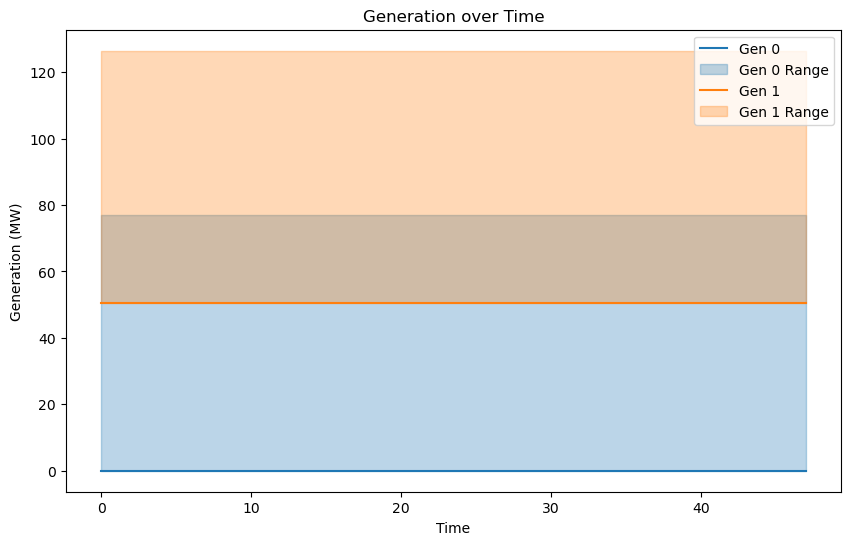

In [12]:
import matplotlib.pyplot as plt

# Plot generation over time for each generator
plt.figure(figsize=(10, 6))
for i in G[:2]:
    generator_data = gen_df[gen_df["Generator"] == i]
    time = generator_data["Time"]
    generation = generator_data["Generation (MW)"]
    p_min = P_min[i]
    p_max = P_max[i]
    (line,) = plt.plot(time, generation, label=f"Gen {i}")

    # Use the same color as the line for the error bar fill
    plt.fill_between(
        time, p_min, p_max, color=line.get_color(), alpha=0.3, label=f"Gen {i} Range"
    )

plt.title("Generation over Time")
plt.xlabel("Time")
plt.ylabel("Generation (MW)")
plt.legend()
plt.show()

In [13]:
print(gen_df.groupby("Generator")["Generation (MW)"].sum())
gen_df

Generator
0       0.000000
1    2427.946775
2    2542.350735
3    4175.855971
4    4761.043303
5    1537.573988
6     690.984863
7    1094.114816
Name: Generation (MW), dtype: float64


,Generator,Time,Generation (MW)
0,0,0,0.0
1,0,1,0.0
2,0,2,0.0
3,0,3,0.0
4,0,4,0.0
...,...,...,...
379,7,43,0.0
380,7,44,0.0
381,7,45,0.0
382,7,46,0.0


In [14]:
flow_df.head()

,Branch,Time,Flow (MW)
0,0,0,137.061867
1,0,1,115.302921
2,0,2,98.769342
3,0,3,96.049533
4,0,4,75.245847


In [15]:
nodes

,node_id,area,lat,lon,exists,comment
0,0,A2,5.488135,7.151894,False,NaN
1,1,A2,8.579456,8.472517,False,NaN
2,2,A1,6.458941,4.375872,True,Acivte
3,3,A1,0.567130,2.726563,False,NaN
4,4,A2,7.917250,5.288949,True,Acivte
5,5,A2,3.927848,8.360788,True,Acivte
6,6,A1,0.871293,0.202184,False,NaN
7,7,A1,9.571552,1.403508,True,Acivte
8,8,A2,9.786183,7.991586,False,NaN
9,9,A2,5.204775,6.788795,False,NaN


    Branch  Time   Flow (MW)  branch_id  node_from  node_to    capacity  \
0        0     0  137.061867          0          0        9  138.247953   
1        1     0 -286.524134          1          0        5  448.441013   
2        2     0  177.128216          2          0        7  367.037322   
3        3     0  177.087191          3          1        8  177.087191   
4        4     0   72.603667          4          1        4  467.236780   
5        5     0 -302.983402          5          1        3  331.872357   
6        6     0  -10.820865          6          2        4  282.359375   
7        7     0 -221.138307          7          2        9  356.940700   
8        8     0  201.610092          8          2        3  201.610092   
9        9     0 -113.704336          9          3        6  320.431659   
10      10     0  152.761300         10          4        7  152.761300   
11      11     0 -180.206405         11          5        7  180.206405   
12      12     0 -154.403

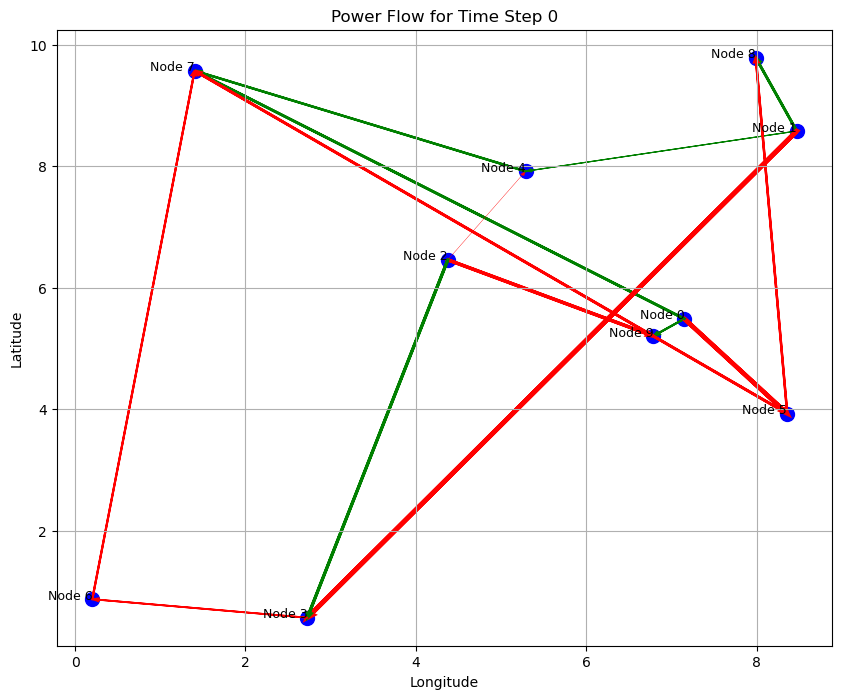

In [24]:
# Step 1: Find the maximum flow magnitude across all time steps
max_flow_magnitude = flow_df["Flow (MW)"].abs().max()

# Define a scaling factor for the arrow thickness (adjust as needed)
scaling_factor = (
    5  # Adjust this value depending on how thick you want the largest arrow to be
)

# Loop through each time step and generate a plot
for t in T[:1]:
    plt.figure(figsize=(10, 8))

    # Merge the flow data with the branch data
    flow_at_time = flow_df[flow_df["Time"] == t].merge(
        branches, left_on="Branch", right_on="branch_id"
    )

    # Extract the node coordinates for node_from and node_to
    flow_at_time = flow_at_time.merge(
        nodes[["node_id", "lat", "lon"]], left_on="node_from", right_on="node_id"
    )
    flow_at_time = flow_at_time.merge(
        nodes[["node_id", "lat", "lon"]],
        left_on="node_to",
        right_on="node_id",
        suffixes=("_from", "_to"),
    )

    print(flow_at_time)
    # Plot the nodes
    for _, node in nodes.iterrows():
        plt.scatter(node["lon"], node["lat"], color="blue", s=100)
        plt.text(
            node["lon"], node["lat"], f'Node {node["node_id"]}', fontsize=9, ha="right"
        )

    # Plot the flows as lines with normalized thickness and arrows for direction
    for _, row in flow_at_time.iterrows():
        # Get coordinates of the from and to nodes
        x_from, y_from = row["lon_from"], row["lat_from"]
        x_to, y_to = row["lon_to"], row["lat_to"]

        # Normalize the magnitude of the flow
        flow_magnitude = abs(row["Flow (MW)"]) / max_flow_magnitude * scaling_factor

        # Plot the flow as an arrow from node_from to node_to
        plt.arrow(
            x_from,
            y_from,
            x_to - x_from,
            y_to - y_from,
            head_width=0.05,
            length_includes_head=True,
            color="red" if row["Flow (MW)"] < 0 else "green",
            linewidth=flow_magnitude,
        )  # Adjust linewidth based on normalized magnitude

    # Add labels and title
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Power Flow for Time Step {t}")
    plt.grid(True)
    plt.show()

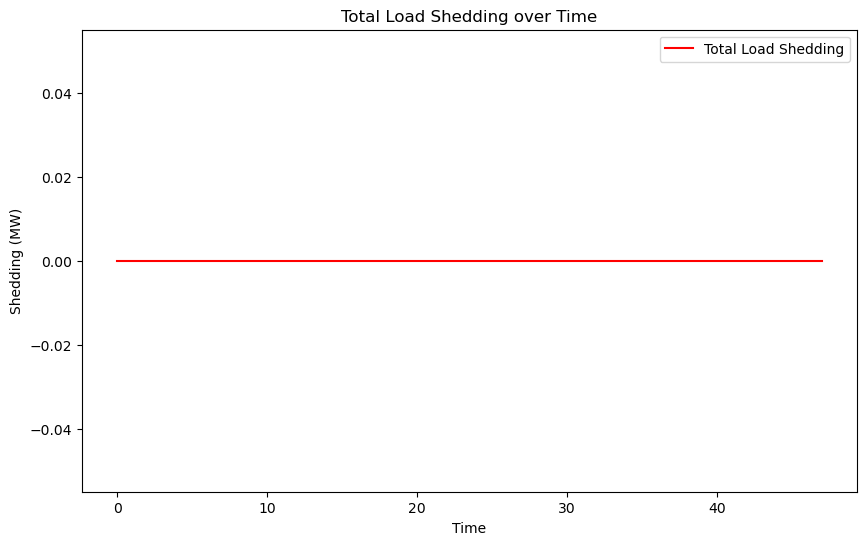

In [25]:
# Plot total shedding over time
plt.figure(figsize=(10, 6))
plt.plot(
    shedding_df.groupby("Time")["Shedding (MW)"].sum(),
    label="Total Load Shedding",
    color="r",
)
plt.title("Total Load Shedding over Time")
plt.xlabel("Time")
plt.ylabel("Shedding (MW)")
plt.legend()
plt.show()

In [26]:
curtailment_df

,Node,Time,Curtailment (MW)
0,0,0,0.000000
1,0,1,0.000000
2,0,2,0.000000
3,0,3,0.000000
4,0,4,0.000000
...,...,...,...
475,9,43,17.878672
476,9,44,5.177428
477,9,45,0.000000
478,9,46,0.000000


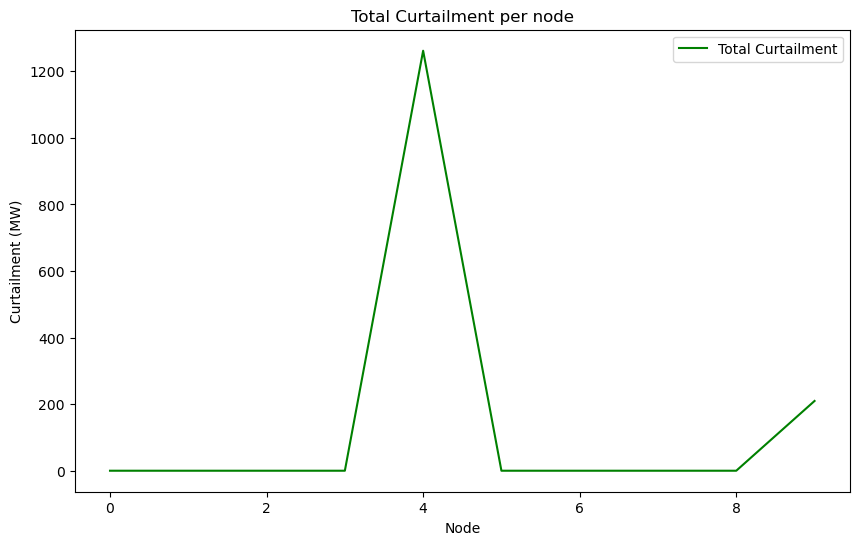

In [27]:
# Plot total curtailment over time
plt.figure(figsize=(10, 6))
plt.plot(
    curtailment_df.groupby("Node")["Curtailment (MW)"].sum(),
    label="Total Curtailment",
    color="g",
)
plt.title("Total Curtailment per node")
plt.xlabel("Node")
plt.ylabel("Curtailment (MW)")
plt.legend()
plt.show()

In [28]:
hourly_demand

,node_id,hour,demand
0,0,0,25.299691
1,0,1,35.728409
2,0,2,34.958830
3,0,3,34.754923
4,0,4,42.855402
...,...,...,...
475,9,43,14.078252
476,9,44,22.104111
477,9,45,20.750885
478,9,46,21.480242


In [29]:
branches

,branch_id,node_from,node_to,capacity,distance,loss_factor
0,0,0,9,138.247953,0.460579,0.004606
1,1,0,5,448.441013,1.973809,0.019738
2,2,0,7,367.037322,7.051116,0.070511
3,3,1,8,177.087191,1.299033,0.012990
4,4,1,4,467.236780,3.251711,0.032517
5,5,1,3,331.872357,9.859684,0.098597
6,6,2,4,282.359375,1.720574,0.017206
7,7,2,9,356.940700,2.719399,0.027194
8,8,2,3,201.610092,6.118305,0.061183
9,9,3,6,320.431659,2.542637,0.025426


In [30]:
branches["node_from"] == 6

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13     True
Name: node_from, dtype: bool

[ 9 13]
<class 'numpy.ndarray'>


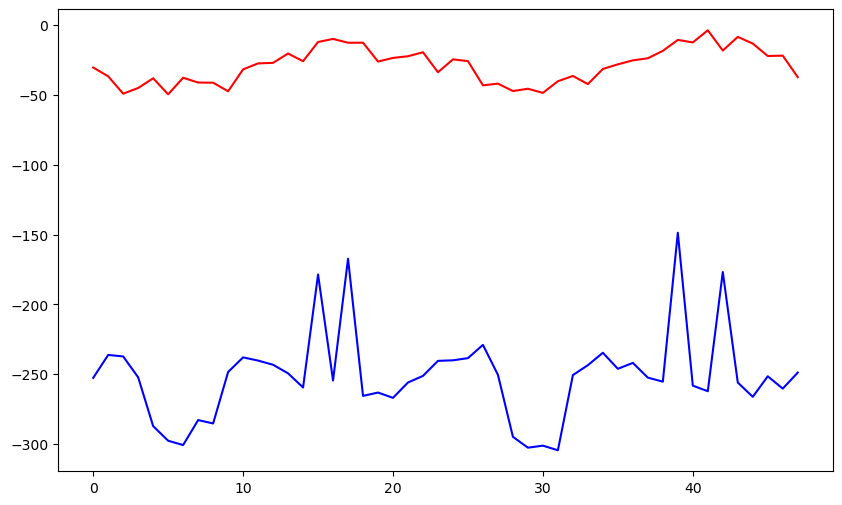

In [31]:
plt.figure(figsize=(10, 6))

branches_connected_to_node_6 = branches[
    (branches["node_from"] == 6) | (branches["node_to"] == 6)
]["branch_id"].values
print(branches_connected_to_node_6)
print(type(branches_connected_to_node_6))
power_flow_node_6 = flow_df[flow_df["Branch"].isin(branches_connected_to_node_6)]
hourly_power_flow_node_6 = power_flow_node_6.groupby("Time")["Flow (MW)"].sum()
plt.plot(hourly_power_flow_node_6, label="Power Flow at Node 6", color="b")
branches_connected_to_node_2 = branches[
    (branches["node_from"] == 2) | (branches["node_to"] == 2)
]["branch_id"].values
power_flow_node_2 = flow_df[flow_df["Branch"].isin(branches_connected_to_node_2)]
hourly_power_flow_node_2 = power_flow_node_2.groupby("Time")["Flow (MW)"].sum()
plt.plot(hourly_power_flow_node_2, label="Power Flow at Node 2", color="r")